NOTE: Please pip install the following (only used to reduce code):

pip install import_ipynb

In [74]:
# import a custom plotting library
import some_plotters as plotter

# import autograd functionality
import autograd.numpy as np

# import path to datasets
datapath = 'datasets/'

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# autoreload functi"on - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### <span style="color:#a50e3e;">Exercise 2: </span>  Imitation Learning on the two-tank problem 

In this exercise you will create a system model - using a small snippet of data for the two-tank problem outlined in the [course notes](https://github.com/jermwatt/control-notes).  This comes from a real life two-tanks experiment - the amount of water allowed into the top tank (per second) - the action sequence $a_t$ - is shown as the black curve in the bottom panel.  In the top panel the *upper* tank water level $s_{1,t}$ is shown in green, and the bottom tank level $s_{2,t}$ is shown in magenta.

In [75]:
import autograd.numpy as np
from autograd import value_and_grad 
from autograd.misc.flatten import flatten_func
import matplotlib.pyplot as plt

# pip install import_ipynb
import import_ipynb
import homework_1_helper_functions

<IPython.core.display.Javascript object>


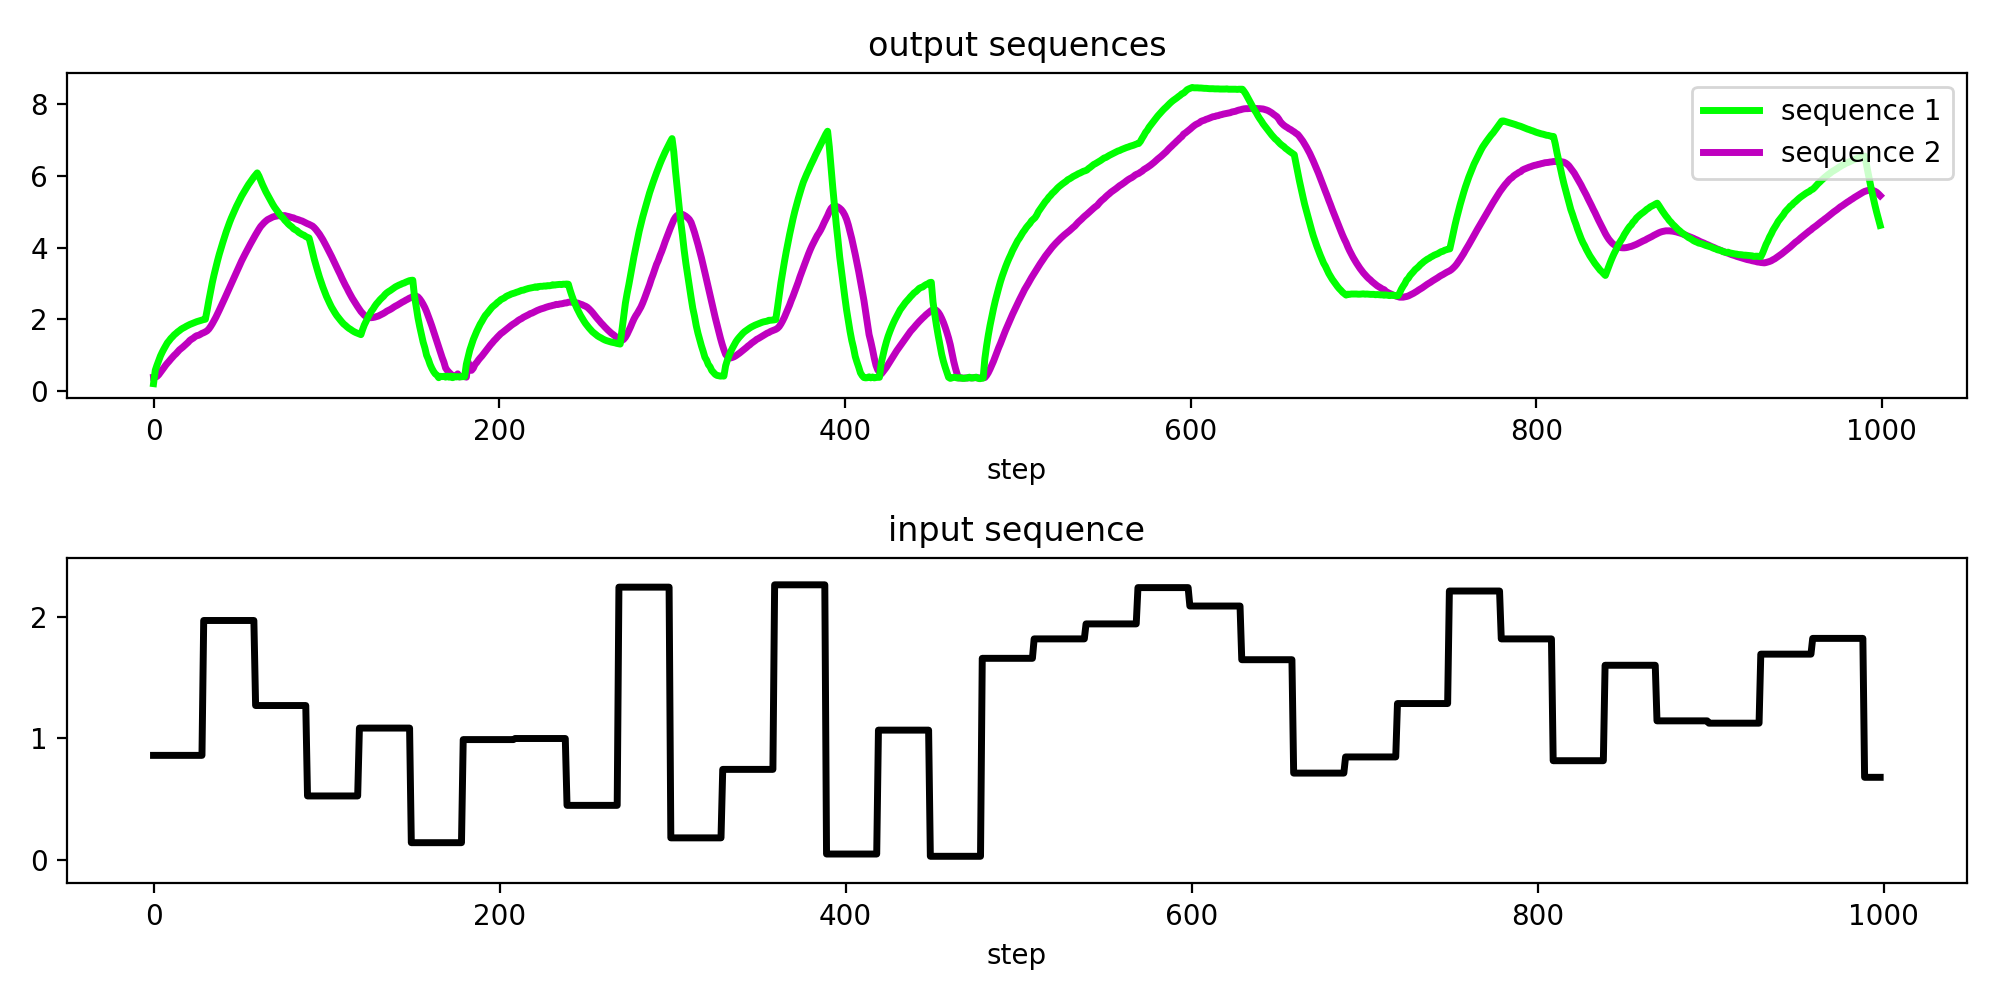

In [76]:
# This code cell will not be shown in the HTML version of this notebook
# load series
data = np.loadtxt(datapath + 'cascaded_tanks_1.csv',delimiter = ',')
actions = data[0:1,1:]
states = data[1:,:]

# plot the test pair
plotter.plot_3fer(actions,states[0],states[1],plot_type = 'continuous')

This system has two $s_{1,t}$ and $s_{2,t}$, hence the Imitator consists of an equation for each.  The upper tank level $s_{1,t}$ is dependent on its own history and - of course- the amount of water $a_t$ that is poured into it.  A simple linear model for this looks like

\begin{equation}
s_{1,t+1} = w_0 + w_1 s_{1,t} + w_2 a_t.
\end{equation}

Since we know that the upper tank drains into the lower one, the simplest sort of system model we can make for the lower tank level $s_{2,t}$ is that it is proportional to its prior value and that of the upper tank, as

\begin{equation}
s_{2,t+1} = w_3 + w_4s_{2,t} + w_5 s_{1,t}.
\end{equation}

Together - using the simplest model for this system we could think of - we have the following two system model equations

\begin{array}
\
s_{1,t+1} = w_0 + w_1 s_{1,t} + w_2 a_t \\
s_{2,t+1} = w_3 + w_4s_{2,t} + w_5 s_{1,t}.
\end{array}

Tune the parameters of this system model $w_0$ through $w_5$ via minimizing a Least Squares cost function so that your imitator learns to mimic the *second tank level* ($s_{2,t}$) - the magenta curve above.

Use the data shown above for training (i.e., you need not cut off a chunk of it for validation - use it all for training).  

Make sure to plot the fit your model provides on the training data.  You can see this exact system model fit to this exact dataset in the course notes - make sure your fit looks fairly similar.

Your result should look something like the one below - shown in dashed black.

<figure>
<p>
<img src= 'images/bottom_tank_approximate.png' width="150%" height="150%" alt=""/>
</p>
</figure>

In [77]:
# watch order
def ord21func(w,s1,a):
    fsa = w[0] + w[1]*s1 + w[2]*a
    return fsa

def ord22func(w,s2,s1,a):
    fsa = w[3] + w[4]*s2 + w[5]*s1
    return fsa

def LSfunc2(w,s,a):
    a = a.T
    T = len(s)
    s1 = s[:]
    s1 = s1[0,:]
    s2 = s[:]
    s2 = s2[1,:]
    s1_0 = s1[0:T-1]
    s1_1 = s1[1:T]
    s2_0 = s2[0:T-1]
    s2_1 = s2[1:T]
    cost1 = (0 + (np.sum(ord21func(w,s1_0,a) - s1_1)**2))/(0 + T-1)
    cost2 = (0 + (np.sum(ord22func(w,s2_0,s1_0,a) - s2_1)**2))/(0 + T-1)
    return cost1+cost2

In [69]:
# actions
a_normalizeR,a_inverse_normalizeR = homework_1_helper_functions.standard_normalizer(actions)
a_normalizeD = a_normalizeR(actions)

# states
s_normalizeR,s_inverse_normalizeR = homework_1_helper_functions.standard_normalizer(states)
s_normalizeD = s_normalizeR(states)

g = lambda w,s=s_normalizeD,a=a_normalizeD: LSfunc2(w,s,a)

#randn(2,1) is out of bounds
w_hist,train_hist = homework_1_helper_functions.gradient_descent(g,
                                                                 w_init=np.random.randn(6,1),
                                                                 alpha=10**(-2),
                                                                 max_its=1000,
                                                                 verbose=False)

# index of the minimum cost value attained
ind = np.argmin(train_hist)

# corresponding weights and cost evaluation
w_best = w_hist[ind]
print("Best weights:\n" + str(w_best))
g_best = train_hist[ind]
print("\nBest cost:\n" + str(g_best))

/Users/ikhlas/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)
/Users/ikhlas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/Users/ikhlas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Best weights:
[[       -inf]
 [        inf]
 [        nan]
 [-0.23749704]
 [ 1.06109436]
 [-0.19649148]]

Best cost:
[nan]


<IPython.core.display.Javascript object>


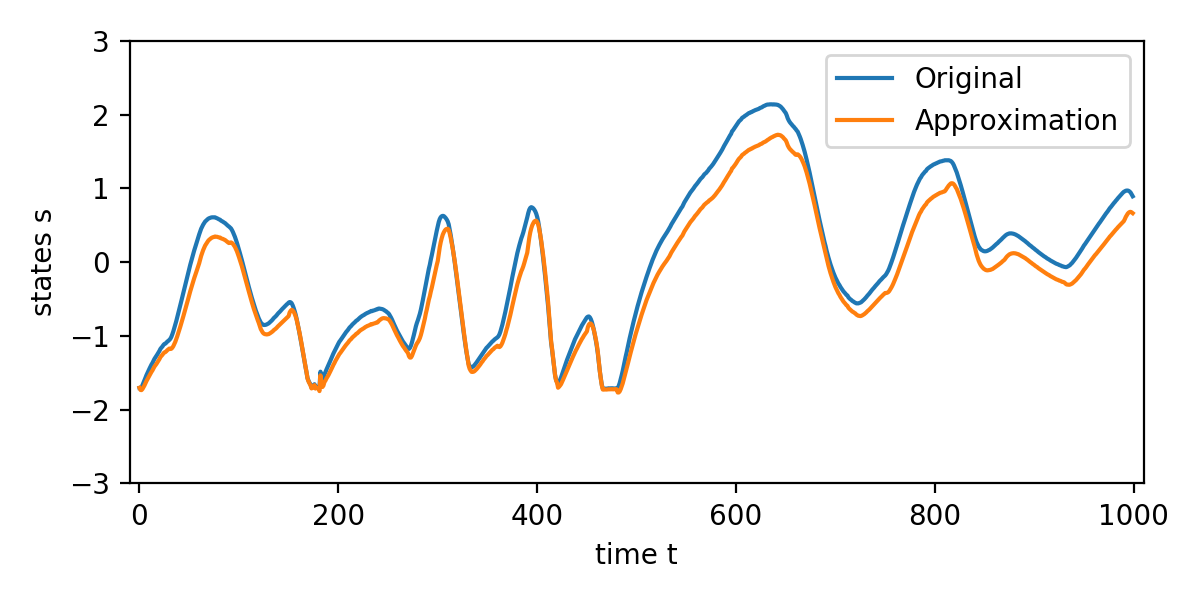

In [93]:

model2 = ord22func(w=w_best,
                   s2=s_normalizeD[1,:],
                   s1=s_normalizeD[0,:],
                   a=a_normalizeD.T)

plt.figure(figsize = (6,3))
plt.ylabel("states s")
plt.xlabel("time t")
axes = plt.gca()
axes.set_xlim([-10,1010])
axes.set_ylim([-3,3])
plt.plot(s_normalizeD[1,:])
plt.plot(model2)
plt.legend(["Original", "Approximation"])
plt.show()

In [91]:
# plt.plot(a_normalizeD.T)